<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Проверка-лучшей-модели-на-адекватность" data-toc-modified-id="Проверка-лучшей-модели-на-адекватность-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Проверка лучшей модели на адекватность</a></span></li><li><span><a href="#Тестирование--и-вывод" data-toc-modified-id="Тестирование--и-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Тестирование  и вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно сделать:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install statsmodels -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score

In [4]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates = [0])

In [5]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 
Для демонстрации DataFrame не стоит выводить все строки разом - это несколько усложнит визуальное восприятие. Чтобы показать просто пару строк - лучше использовать методы `head()/tail()/sample()`, если нужно оценить количество строк - можно использовать метод `shape` или функцию `len`:)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
data.sort_index(inplace=True)

In [8]:
data.isna().sum()

num_orders    0
dtype: int64

In [9]:
data.index.is_monotonic_increasing

True

- Пропусков нет, последовательность соблюдается

In [10]:
#  выполним их ресемплирование по одному часу.
data = data.resample('1H').sum()

In [11]:
print(f"Временной промежуток данных: {data.index.min()} - {data.index.max()}")

Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


## Анализ

In [12]:
decomposed = seasonal_decompose(data['2018-04':'2018-04'])

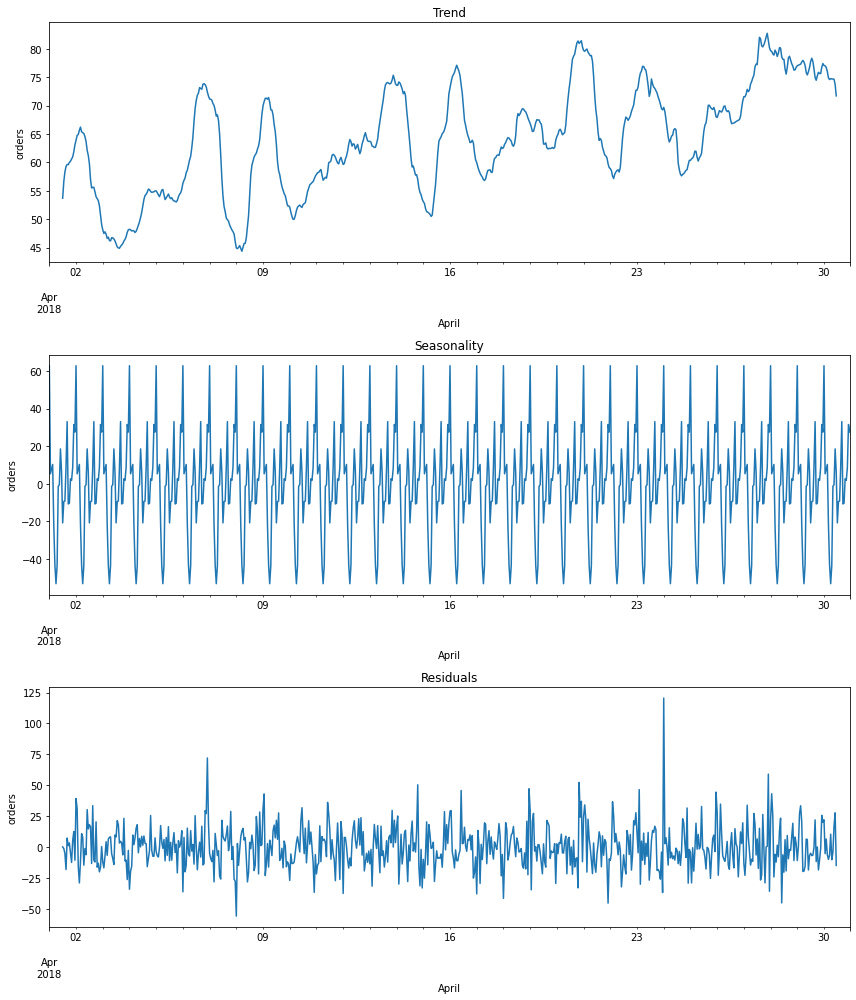

In [13]:
plt.figure(figsize=(12, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('April')
plt.ylabel('orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('April')
plt.ylabel('orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('April')
plt.ylabel('orders')
plt.tight_layout()

- к воскресенью обычно падает спрос, а в понелельник как раз возрастает, всё-таки начало рабочей недели   
_P.S. 1 апреля 2018 - это воскресенье_

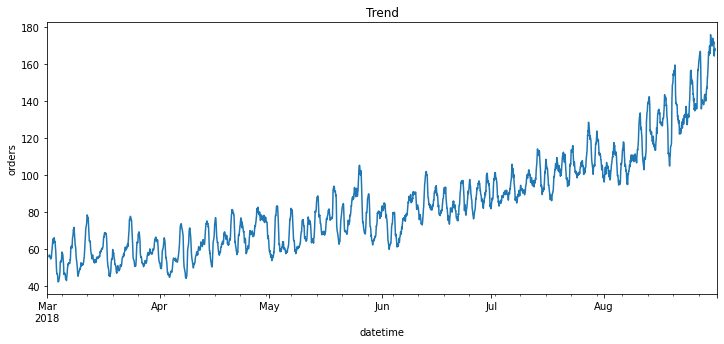

In [14]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.ylabel('orders')
plt.title('Trend');

- заметен тренд роста спроса к лету и далее на протяжении тёплого периода

In [15]:
decomposed = seasonal_decompose(data['2018-04-01':'2018-04-03'])

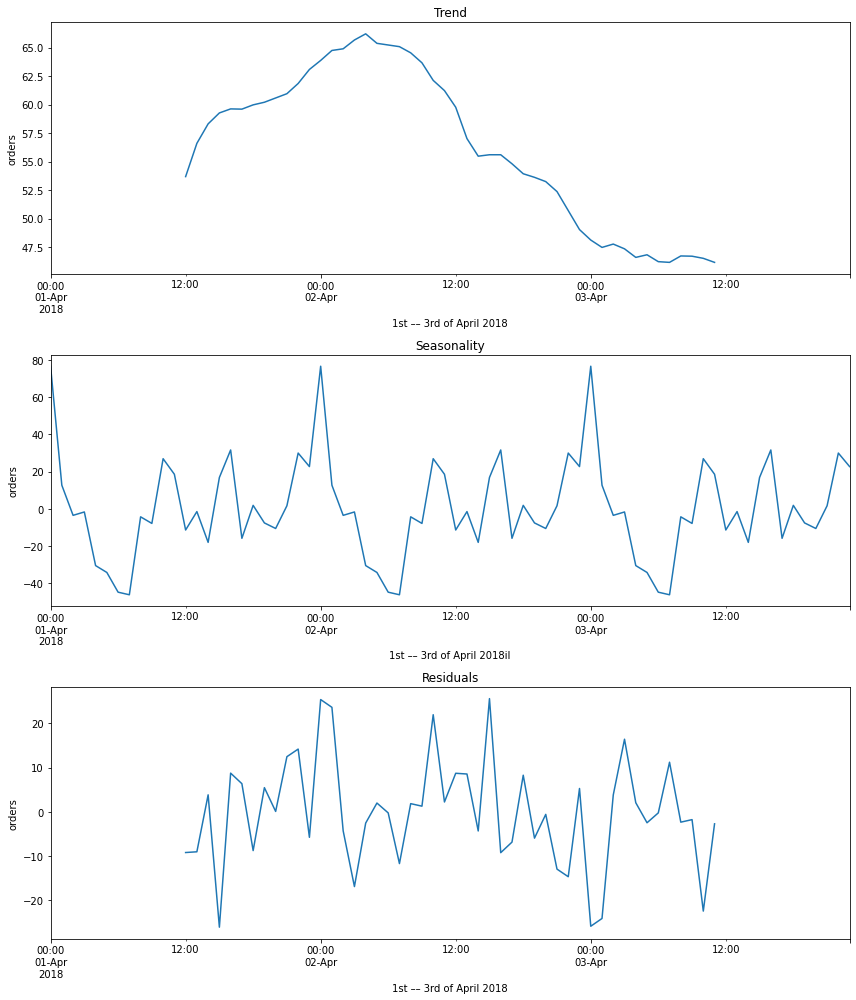

In [16]:
plt.figure(figsize=(12, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('1st –– 3rd of April 2018')
plt.ylabel('orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('1st –– 3rd of April 2018il')
plt.ylabel('orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.xlabel('1st –– 3rd of April 2018')
plt.ylabel('orders')
plt.tight_layout()

- наблюдается суточная сезонность, обычно максимальное число заказов достигается в 12 часов ночи (00:00)    
- часто самолёты прибывают вечером и пока люди получат багаж они как раз и выходят из аэропорта около 00:00

In [17]:
dff = data.copy()
dff['mean'] = dff['num_orders'].shift().rolling(15).mean()
dff['std'] = dff['num_orders'].shift().rolling(15).std()

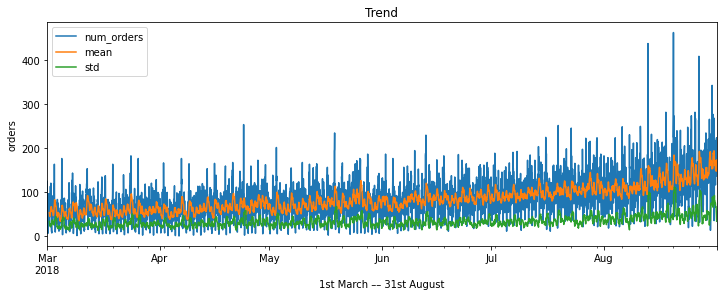

In [18]:
plt.figure(figsize=(12, 14))
plt.subplot(311)
dff.plot(ax=plt.gca()) 
plt.title('Trend')
plt.xlabel('1st March –– 31st August')
plt.ylabel('orders')
plt.show()

- сглаженное среднее увеличивается со временем, значит ряд не стационарен
- дополнительно проверим это на тесте Дики — Фуллера 

- формулируем гипотезы:    
- - H0: временной ряд не стационарный
- - H1: временной ряд стационарный

In [19]:
# проведём тест Дики — Фуллера 
adfuller(data)

(-3.0689242890279558,
 0.028940051402612906,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

- Статистика теста: -3.06892
- p-value: 0.02894

Поскольку p-value < 0.05, мы отвергаем нулевую гипотезу. Это означает, что временной ряд является стационарным.                            
В то же время p-value > 0.01, это означает, что временной ряд является не стационарным.      
Т.к. графический анализ, который мы провели выше указывает на наличие тренда и изменение скользящего среднего во времени, то нулевая гипотеза не отвергаеися и значит **ряд является не стационарным.**

In [20]:
# напишем функцию для создания обучающих признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [21]:
# в этом цикле будем осуществлять подбор лучших параметров, чтобы RMSE модели 
# на тестовой выборке не превоскодило значение 48
RMSE = 48

best_lag = 0
best_rolling = 0


for lag in range(20, 71, 5):
    for rolling in range(1, 21, 5):
        df = make_features(data, lag, rolling)
        train, test = train_test_split(df, shuffle=False, test_size = 0.1)
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        X_test = test.drop('num_orders', axis = 1)
        y_test = test['num_orders']
        
        model = LinearRegression()
        rmse = cross_val_score(model,
                X_train, 
                y_train, 
                cv = TimeSeriesSplit(n_splits=4), 
                n_jobs = -1, 
                scoring = 'neg_root_mean_squared_error').mean() * (-1)
        if rmse < RMSE:
            RMSE = rmse
            best_rolling = rolling
            best_lag = lag
print(f'Лучший показатель rmse на кросс-валидации: {RMSE}')
print(f'Размер скользящего окна: {best_rolling}')
print(f'Максимальное смещение: {best_lag}')

Лучший показатель rmse на кросс-валидации: 25.012912535906302
Размер скользящего окна: 16
Максимальное смещение: 50


In [22]:
data = make_features(data, best_lag, best_rolling)
train, test = train_test_split(data, shuffle=False, test_size = 0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

- подобрали подходящие параметры для добавления признаков, чтобы RMSE на тестовой выборке не превосходило 48

## Обучение

In [23]:
models = ['LinearRegression', 'CatBoost', 'LightGBM']
results = list()

## LinearRegression

In [24]:
model = LinearRegression()
rmse = cross_val_score(model,
                X_train, 
                y_train, 
                cv = TimeSeriesSplit(n_splits=4), 
                n_jobs = -1, 
                scoring = 'neg_root_mean_squared_error').mean() * (-1)
print("RMSE с кросс-валидации:", rmse)

RMSE с кросс-валидации: 25.21910697410158


In [25]:
results.append(rmse)

## CatBoost

In [26]:
RANDOM_STATE = 42

params = [
    
    # словарь для модели DecisionTreeRegressor()
    {
       'max_depth': range(1, 8, 2),
        'iterations': range(10, 30, 5),
        'learning_rate': np.arange(0.01, 0.5, 0.05)
    }
]

In [27]:
tcv = TimeSeriesSplit(n_splits=4)
gatto = CatBoostRegressor(random_seed=42,
                        loss_function='RMSE',
                        silent=True,
                        border_count=None)

random_1 = RandomizedSearchCV(
    gatto, 
    params, 
    cv=tcv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

In [28]:
random_1.fit(X_train, y_train)
rmse_1 = random_1.best_score_ * (-1)
print("RMSE с кросс-валидации:", rmse_1)

RMSE с кросс-валидации: 25.539811334147966


In [29]:
best_model_1 = random_1.best_estimator_

In [30]:
results.append(rmse_1)

## LightGBM

In [31]:
gbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=42)


params = {
    'learning_rate': np.logspace(-5, 0, 5),
    'n_estimators': [30, 5],
    'num_leaves': [20, 30, 40],
}

random_2 = RandomizedSearchCV(gbm,
                        params,
                        cv=tcv,
                        scoring='neg_root_mean_squared_error',
                        verbose=True,
                        random_state=RANDOM_STATE)

In [32]:
random_2.fit(X_train, y_train)
rmse_2 = random_2.best_score_ * (-1)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.195912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.196113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-

In [33]:
print("RMSE с кросс-валидации:", rmse_2)

RMSE с кросс-валидации: 29.824415638212333


In [34]:
best_model_2 = random_2.best_estimator_

In [35]:
results.append(rmse_2)

- у всех моделей RMSE на кросс-валидации не превосходит отметку в 48

## Анализ моделей

In [36]:
table = pd.DataFrame({
    'model': models,
    'RMSE': results
})

table

,model,RMSE
0,LinearRegression,25.219107
1,CatBoost,25.539811
2,LightGBM,29.824416


В целом все модели примерно одинаково хороши.   
**Лучшая модель –– LinearRegression** 


## Проверка лучшей модели на адекватность

In [37]:
# Прогноз с использованием предыдущего значения ряда
pred_previous = test['num_orders'].shift()

# Заполнение первого значения предыдущим значением ряда
pred_previous.iloc[0] = train['num_orders'].iloc[-1]

# Вычисление MAE
rmse = mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print('RMSE:', rmse)

RMSE: 58.856486242815066


- выбранная модель адекватна, всё в порядке

In [38]:
model.fit(X_train, y_train)
pred = model.predict(X_test)
rmse = mean_squared_error(y_test, pred) ** 0.5
print('RMSE лучшей модели на тестовой выборке:', rmse)

RMSE лучшей модели на тестовой выборке: 41.859592682838624


## Тестирование  и вывод

In [39]:
preds = pd.DataFrame(pred, index = y_test.index)

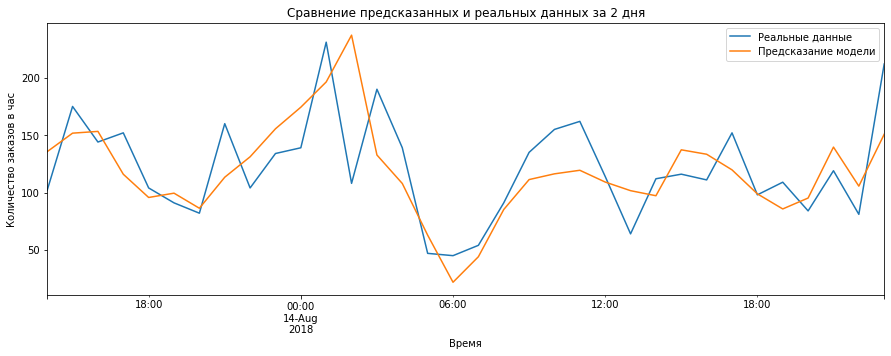

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot()

y_test['2018-08-12':'2018-08-14'].plot(ax=plt.gca(), label='Реальные данные')
preds['2018-08-12':'2018-08-14'].plot(ax=plt.gca(), label='Предсказание модели')

plt.legend(['Реальные данные', 'Предсказание модели'])
plt.xlabel('Время')
plt.ylabel('Количество заказов в час')

plt.title('Сравнение предсказанных и реальных данных за 2 дня')
plt.show()

- модель хорошо предсказывает спрос, достаточно точно устанавливая максимумы и минимумы на графике
